In [1]:
%matplotlib inline

import numpy as np
import datetime as dt
import pandas as pd
import os
import xarray as xr
import matplotlib.pyplot as plt
from bokeh.plotting import figure, output_file, save
from bokeh.io import reset_output
import bokeh
import cartopy.crs as ccrs
import cartopy
import cartopy.io.shapereader as shpreader

In [10]:
# ===================================================== #
# Parameters
# ===================================================== #
# --- USGS data --- #
# Site info file; needs to have columns "short_name" and "site_no"
site_info_csv = '/civil/hydro/ymao/data_assim/data/USGS/Crow_2017/sites_in_ArkRed/site_info_in_ArkRed.csv'
# Directory of USGS data
usgs_data_dir = '/civil/hydro/ymao/data_assim/data/USGS/Crow_2017/sites_in_ArkRed/'

# --- Domain file ("mask" and "area" will be used) --- #
domain_nc = '/civil/hydro/ymao/data_assim/param/vic/ArkRed/ArkRed.domain.nc'

# --- RVIC output param remap nc files --- #
# "{}" will be replaced by site name
rvic_subbasin_nc = '/civil/hydro/ymao/data_assim/param/RVIC/ArkRed/parameter/' \
                   'param_run_output.8sites_Crow2017/temp/remapped/remapUH_{}.nc'

# --- NLDAS-2 precipitation forcing basepath (YYYY.nc will be appended) --- #
nldas2_basepath = '/civil/hydro/ymao/data_assim/forcing/vic/NLDAS-2/ArkRed/force.'
    
# --- Output --- #
output_dir = '/civil/hydro/ymao/data_assim/tools/process_evaluation_data_ArkRed/' \
             'output/20180906.basin_map/'

In [6]:
# ===================================================== #
# Load USGS data
# ===================================================== #
# --- Load site info --- #
df_site_info = pd.read_csv(site_info_csv, dtype={'site_no': str})
dict_sites = {}  # {site: site_no}
for i in df_site_info.index:
    site = df_site_info.loc[i, 'short_name']
    site_no = df_site_info.loc[i, 'site_no']
    dict_sites[site] = site_no

# --- Get USGS drainage area (mi2) --- #
dict_usgs_drainage_area = {}  # {site: area}
for i in df_site_info.index:
    site = df_site_info.loc[i, 'short_name']
    drainage_area = df_site_info.loc[i, 'drain_area_va']
    dict_usgs_drainage_area[site] = drainage_area * 1.60934 * 1.60934  # convert [mi2] to [km2]
    
# --- Load basin number (simply in the order in the site_info csv file starting from 1) --- #
dict_basin_number = {}  # {site: basin_number}
for i in df_site_info.index:
    site = df_site_info.loc[i, 'short_name']
    basin_number = i + 1
    dict_basin_number[site] = basin_number

In [7]:
df_site_info

,agency_cd,site_no,station_nm,short_name,dec_lat_va,dec_long_va,coord_acy_cd,dec_coord_datum_cd,huc_cd,basin_cd,drain_area_va,in_ArkRed,grid_lat_8th,grid_lon_8th,Note
0,USGS,07144200,"L ARKANSAS R AT VALLEY CENTER, KS",arkansas,37.832234,-97.388932,M,NAD83,11030012,7.0,1327,Yes,37.9375,-97.4375,Different grid cell from the cell that it fall...
1,USGS,07144780,"NF NINNESCAH R AB CHENEY RE, KS",ninnescah,37.862513,-98.013945,M,NAD83,11030014,7.0,713,Yes,37.8125,-98.0625,NaN
2,USGS,07147800,"WALNUT R AT WINFIELD, KS",walnut,37.223916,-96.996147,M,NAD83,11030018,7.0,1880,Yes,37.1875,-96.9375,NaN
3,USGS,07152000,"Chikaskia River near Blackwell, OK",chikaskia,36.811421,-97.277265,S,NAD83,11060005,2.0,1876,Yes,36.8125,-97.3125,NaN
4,USGS,07177500,"Bird Creek near Sperry, OK",bird,36.278425,-95.954162,F,NAD83,11070107,2.0,907,Yes,36.3125,-95.9375,NaN
5,USGS,07186000,"Spring River near Waco, MO",spring,37.245611,-94.566417,C,NAD83,11070207,NaN,1164,Yes,37.1875,-94.5625,NaN
6,USGS,07196500,"Illinois River near Tahlequah, OK",illinois,35.922869,-94.923566,F,NAD83,11110103,2.0,950,Yes,35.9375,-94.9375,NaN
7,USGS,07243500,"Deep Fork near Beggs, OK",deep,35.673988,-96.068608,U,NAD83,11100303,2.0,2004,Yes,35.6875,-96.0625,NaN


In [8]:
# ===================================================== #
# Load basin information
# ===================================================== #
ds_domain = xr.open_dataset(domain_nc)
da_area = ds_domain['area']
da_domain = ds_domain['mask']

# --- Basin domain --- #
dict_da_frac = {}
for site in dict_sites.keys():
    da_frac = xr.open_dataset(rvic_subbasin_nc.format(site))['fraction']
    dict_da_frac[site] = da_frac

# --- Basin area --- #
dict_basin_area = {}
for site in dict_sites.keys():
    basin_area = float(da_area.where(dict_da_frac[site]>0).sum())  # [m2]
    basin_area = basin_area / 1000 / 1000  # convert to [km2]
    dict_basin_area[site] = basin_area
    print(site, basin_area)

arkansas 3489.61244685949
bird 3103.7095348407056
deep 4863.3081974647885
illinois 3276.8724308692413
ninnescah 1983.1028074048015
walnut 5043.581406236542
spring 5075.144257650728
chikaskia 4310.18946663719


/civil/hydro/ymao/anaconda3/envs/da2/lib/python3.5/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


# Plot subbasins on the map

/civil/hydro/ymao/anaconda3/envs/da2/lib/python3.5/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):
/civil/hydro/ymao/anaconda3/envs/da2/lib/python3.5/site-packages/xarray/core/dtypes.py:25: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  elif np.issubdtype(dtype, int):
/civil/hydro/ymao/anaconda3/envs/da2/lib/python3.5/site-packages/xarray/plot/utils.py:51: FutureWarning: 'pandas.tseries.converter.register' has been moved and renamed to 'pandas.plotting.register_matplotlib_converters'. 
  converter.register()


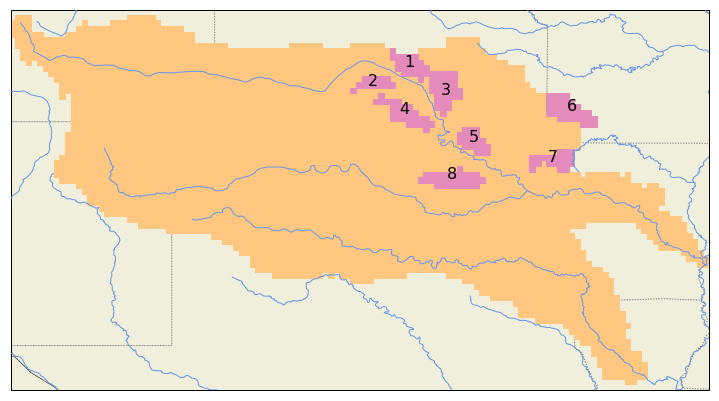

In [9]:
# ===================================================== #
# Plot subbasins on the map
# ===================================================== #
fig = plt.figure(figsize=(14, 7))
# Set projection
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-106.6, -91, 31, 39.5], ccrs.Geodetic())
#gl = add_gridlines(ax, xlocs=[-95, -100, -105], ylocs=[32, 35, 38], alpha=0)
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.BORDERS, linestyle='-')
ax.add_feature(cartopy.feature.LAKES, alpha=0.5)
# Add states
shapename = 'admin_1_states_provinces_lakes_shp'
states_shp = shpreader.natural_earth(resolution='110m',
                                     category='cultural', name=shapename)
for state in shpreader.Reader(states_shp).geometries():
    # pick a default color for the land with a black outline,
    # this will change if the storm intersects with our track
    facecolor=[0.9375, 0.9375, 0.859375]
    edgecolor='grey'
    ax.add_geometries([state], ccrs.PlateCarree(),
                      facecolor=facecolor, edgecolor=edgecolor, linestyle=':')
# Add rivers
rivers = cartopy.feature.NaturalEarthFeature(
    category='physical', name='rivers_lake_centerlines',
    scale='10m', facecolor='none', edgecolor='cornflowerblue')
ax.add_feature(rivers, zorder=3)
# Plot ArkRed mask
cs = da_domain.where(da_domain==1).plot.pcolormesh(
    'lon', 'lat', axes=ax,
    add_colorbar=False,
    add_labels=False,
    cmap='copper',
    vmin=0, vmax=1,
    transform=ccrs.PlateCarree(),
    zorder=2)
# Plot subbasins with basin number
for site in dict_sites.keys():
    # Plot basin mask
    cs = da_domain.where(dict_da_frac[site]>0).plot.pcolormesh(
        'lon', 'lat', axes=ax,
        add_colorbar=False,
        add_labels=False,
        cmap='PiYG_r',
        vmin=0, vmax=1.3,
        transform=ccrs.PlateCarree(),
        zorder=2)
    # Add basin number
    lat_inds, lon_inds = np.where(dict_da_frac[site].values>0)
    lat_min = da_domain['lat'][lat_inds.min()].values
    lat_max = da_domain['lat'][lat_inds.max()].values
    lon_min = da_domain['lon'][lon_inds.min()].values
    lon_max = da_domain['lon'][lon_inds.max()].values
    lat_center = (lat_min + lat_max) / 2
    lon_center = (lon_min + lon_max) / 2
    plt.text(lon_center, lat_center, '{}'.format(dict_basin_number[site]),
         horizontalalignment='center', fontsize=16,
         transform=ccrs.Geodetic())
    
fig.savefig(os.path.join(output_dir,
                         'ArkRed_map_subbasins.png'),
            format='png', bbox_inches='tight', pad_inches=0)

# Plot subbasins on the map - with precipitation climatology

In [17]:
nldas2_basepath + '{}.nc'

'/civil/hydro/ymao/data_assim/forcing/vic/NLDAS-2/ArkRed/force.{}.nc'

In [20]:
# ===================================================== #
# Load NLDAS-2 precipitation data and calculate climatology
# ===================================================== #
# Load data
list_da_prec = []
for y in range(1979, 2018):
    da = xr.open_dataset('{}{}.nc'.format(nldas2_basepath, y))['PREC']
    list_da_prec.append(da)

In [21]:
da_prec_allyears = xr.concat(list_da_prec, dim='time')

In [26]:
# Calculate climatology mean
da_prec_mean = da_prec_allyears.sum(dim='time') / (2017-1979+1)  # mm/year

In [37]:
da_prec_mean.max()

<xarray.DataArray 'PREC' ()>
array(1552.107565)

/civil/hydro/ymao/anaconda3/envs/da2/lib/python3.5/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):
/civil/hydro/ymao/anaconda3/envs/da2/lib/python3.5/site-packages/xarray/core/dtypes.py:25: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  elif np.issubdtype(dtype, int):


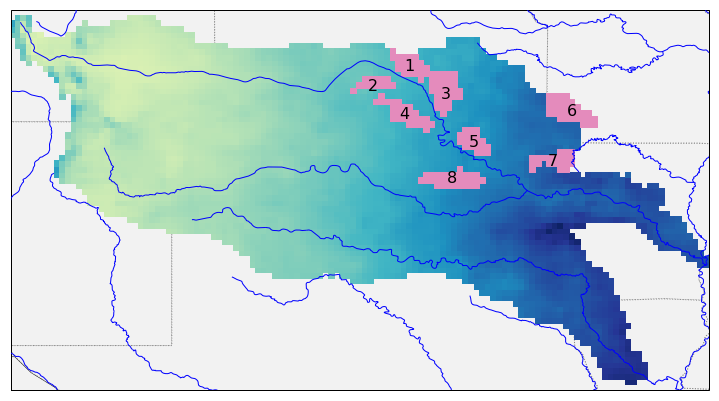

In [69]:
# ===================================================== #
# Plot subbasins on the map - with precipitation climatology
# ===================================================== #
fig = plt.figure(figsize=(14, 7))
# Set projection
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-106.6, -91, 31, 39.5], ccrs.Geodetic())
#gl = add_gridlines(ax, xlocs=[-95, -100, -105], ylocs=[32, 35, 38], alpha=0)
ax.add_feature(cartopy.feature.LAND, facecolor=[0.95, 0.95, 0.95])
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.BORDERS, linestyle='-')
ax.add_feature(cartopy.feature.LAKES, alpha=0.5)
# Add states
shapename = 'admin_1_states_provinces_lakes_shp'
states_shp = shpreader.natural_earth(resolution='110m',
                                     category='cultural', name=shapename)
for state in shpreader.Reader(states_shp).geometries():
    # pick a default color for the land with a black outline,
    # this will change if the storm intersects with our track
    #facecolor=[0.9375, 0.9375, 0.859375]
    facecolor=[0.95, 0.95, 0.95]
    edgecolor='grey'
    ax.add_geometries([state], ccrs.PlateCarree(),
                      facecolor=facecolor, edgecolor=edgecolor, linestyle=':')
# Add rivers
rivers = cartopy.feature.NaturalEarthFeature(
    category='physical', name='rivers_lake_centerlines',
    scale='10m', facecolor='none', edgecolor='blue')
ax.add_feature(rivers, zorder=3)
# Plot ArkRed mask with precipitation
cs = da_prec_mean.where(da_domain==1).plot.pcolormesh(
    'lon', 'lat', axes=ax,
    add_colorbar=False,
    add_labels=False,
    cmap='YlGnBu',
    vmin=0, vmax=1600,
    transform=ccrs.PlateCarree(),
    zorder=2)
# Plot subbasins with basin number
for site in dict_sites.keys():
    # Plot basin mask
    cs = da_domain.where(dict_da_frac[site]>0).plot.pcolormesh(
        'lon', 'lat', axes=ax,
        add_colorbar=False,
        add_labels=False,
        cmap='PiYG_r',
        vmin=0, vmax=1.3,
        transform=ccrs.PlateCarree(),
        zorder=2)
    # Add basin number
    lat_inds, lon_inds = np.where(dict_da_frac[site].values>0)
    lat_min = da_domain['lat'][lat_inds.min()].values
    lat_max = da_domain['lat'][lat_inds.max()].values
    lon_min = da_domain['lon'][lon_inds.min()].values
    lon_max = da_domain['lon'][lon_inds.max()].values
    lat_center = (lat_min + lat_max) / 2
    lon_center = (lon_min + lon_max) / 2
    plt.text(lon_center, lat_center-0.1, '{}'.format(dict_basin_number[site]),
         horizontalalignment='center', fontsize=16,
         transform=ccrs.Geodetic())
    
fig.savefig(os.path.join(output_dir,
                         'ArkRed_map_subbasins.png'),
            format='png', bbox_inches='tight', pad_inches=0)

/civil/hydro/ymao/anaconda3/envs/da2/lib/python3.5/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


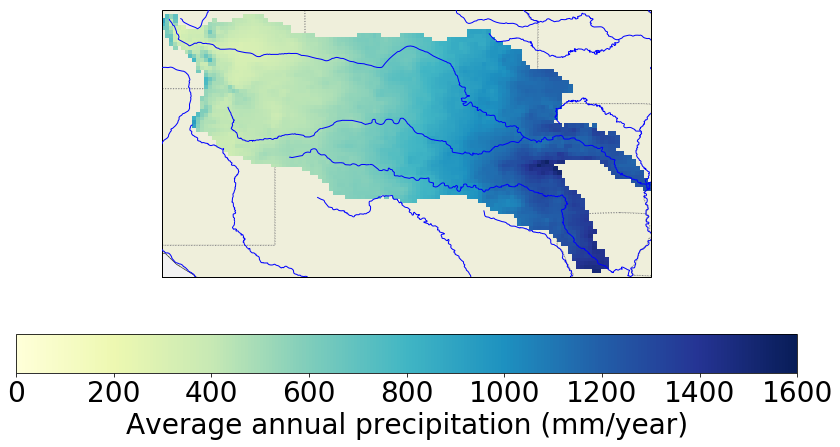

In [72]:
# ===================================================== #
# Plot subbasins on the map - with precipitation climatology
# ===================================================== #
fig = plt.figure(figsize=(14, 7))
# Set projection
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-106.6, -91, 31, 39.5], ccrs.Geodetic())
#gl = add_gridlines(ax, xlocs=[-95, -100, -105], ylocs=[32, 35, 38], alpha=0)
ax.add_feature(cartopy.feature.LAND, facecolor=[0.95, 0.95, 0.95])
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.BORDERS, linestyle='-')
ax.add_feature(cartopy.feature.LAKES, alpha=0.5)
# Add states
shapename = 'admin_1_states_provinces_lakes_shp'
states_shp = shpreader.natural_earth(resolution='110m',
                                     category='cultural', name=shapename)
for state in shpreader.Reader(states_shp).geometries():
    # pick a default color for the land with a black outline,
    # this will change if the storm intersects with our track
    facecolor=[0.9375, 0.9375, 0.859375]
    #facecolor=[0.95, 0.95, 0.95]
    edgecolor='grey'
    ax.add_geometries([state], ccrs.PlateCarree(),
                      facecolor=facecolor, edgecolor=edgecolor, linestyle=':')
# Add rivers
rivers = cartopy.feature.NaturalEarthFeature(
    category='physical', name='rivers_lake_centerlines',
    scale='10m', facecolor='none', edgecolor='blue')
ax.add_feature(rivers, zorder=3)
# Plot ArkRed mask with precipitation
cs = da_prec_mean.where(da_domain==1).plot.pcolormesh(
    'lon', 'lat', axes=ax,
    add_colorbar=False,
    add_labels=False,
    cmap='YlGnBu',
    vmin=0, vmax=1600,
    transform=ccrs.PlateCarree(),
    zorder=2)
cbar = plt.colorbar(cs, orientation='horizontal')
cbar.set_label(
    'Average annual precipitation (mm/year)', fontsize=28)
for t in cbar.ax.get_xticklabels():
    t.set_fontsize(28)

fig.savefig(os.path.join(output_dir,
                         'ArkRed_map_subbasins.colorbar.png'),
            format='png', bbox_inches='tight', pad_inches=0)

# Plot U.S. map

/civil/hydro/ymao/anaconda3/envs/da2/lib/python3.5/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):
/civil/hydro/ymao/anaconda3/envs/da2/lib/python3.5/site-packages/xarray/core/dtypes.py:25: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  elif np.issubdtype(dtype, int):


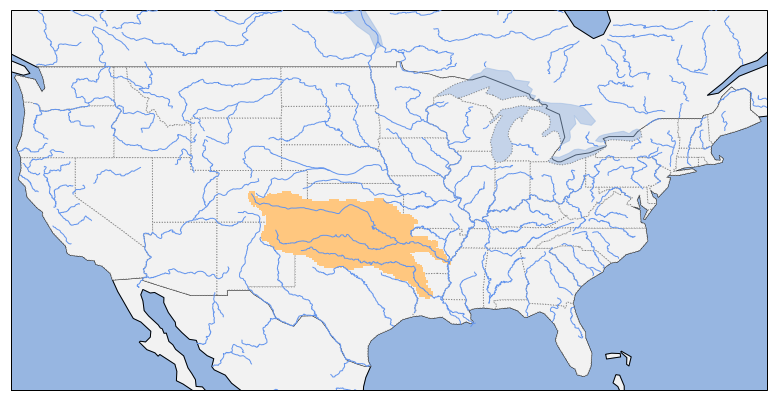

In [78]:
# ======================================================== #
# ArkRed map
# ======================================================== #
fig = plt.figure(figsize=(14, 7))
# Set projection
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-125, -66.5, 24, 50], ccrs.Geodetic())
#gl = add_gridlines(ax, xlocs=[-95, -100, -105], ylocs=[32, 35, 38], alpha=0)
ax.add_feature(cartopy.feature.LAND, facecolor=[0.95, 0.95, 0.95])
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.BORDERS, linestyle='-')
ax.add_feature(cartopy.feature.LAKES, alpha=0.5)
# Add states
shapename = 'admin_1_states_provinces_lakes_shp'
states_shp = shpreader.natural_earth(resolution='110m',
                                     category='cultural', name=shapename)
for state in shpreader.Reader(states_shp).geometries():
    # pick a default color for the land with a black outline,
    # this will change if the storm intersects with our track
#    facecolor=[0.9375, 0.9375, 0.859375]
    facecolor=[0.95, 0.95, 0.95]
    edgecolor='grey'
    ax.add_geometries([state], ccrs.PlateCarree(),
                      facecolor=facecolor, edgecolor=edgecolor, linestyle=':')
# Add rivers
rivers = cartopy.feature.NaturalEarthFeature(
    category='physical', name='rivers_lake_centerlines',
    scale='10m', facecolor='none', edgecolor='cornflowerblue')
ax.add_feature(rivers, zorder=3)
# Plot
cs = da_domain.where(da_domain==1).plot.pcolormesh(
    'lon', 'lat', axes=ax,
    add_colorbar=False,
    add_labels=False,
    cmap='copper',
    vmin=0, vmax=1,
    transform=ccrs.PlateCarree(),
    zorder=2)
fig.savefig(os.path.join(output_dir,
                         'US_map.png'),
            format='png', bbox_inches='tight', pad_inches=0)

# Functions

In [11]:
def load_nc_file(nc_file, start_year, end_year):
    ''' Loads in nc files for all years.

    Parameters
    ----------
    nc_file: <str>
        netCDF file to load, with {} to be substituted by YYYY
    start_year: <int>
        Start year
    end_year: <int>
        End year

    Returns
    ----------
    ds_all_years: <xr.Dataset>
        Dataset of all years
    '''

    list_ds = []
    for year in range(start_year, end_year+1):
        # Load data
        fname = nc_file.format(year)
        ds = xr.open_dataset(fname)
        list_ds.append(ds)
        # Concat all years
        ds_all_years = xr.concat(list_ds, dim='time')

    return ds_all_years